In [1]:
import gpytorch

from bo_functions import best_error_advanced
from bo_functions import calc_ei_advanced
from bo_functions import LHS_Design
from bo_functions import create_y_data
from bo_functions import test_train_split
from bo_functions import ExactGPModel
from bo_functions import train_GP_model
from bo_functions import calc_GP_outputs
from bo_functions import calc_y_expected
from bo_functions import improvement_integral
from bo_functions import improvement_int_terms

from bo_plotters import plotter_adv
from bo_plotters import y_plotter_adv
from bo_plotters import stdev_plotter_adv
from bo_plotters import ei_plotter_adv
from bo_plotters import improvement_integral_plot
from bo_plotters import improvement_int_terms_plot

In [2]:
#Set noise parameters and load csv file to generate training data
noise_std = 0.1**2
all_p = LHS_Design("LHS_Toy_3_Input.csv")
all_y = create_y_data(all_p, noise_std)

#Separate training and testing data, uses default of an 80%/20% split
train_test_data = test_train_split(all_p,all_y)

train_p = train_test_data[0] #1x19
train_y = train_test_data[1] #1x19
test_p = train_test_data[2] #1x19
test_y = train_test_data[3] #1x19

In [3]:
# initialize likelihood and model
##Assumes a homoskedastic noise model p(y | f) = f + noise
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# We will use the simplest form of GP model, exact inference
#Defines our model in terms of the class parameters in bo_functions
model = ExactGPModel(train_p, train_y, likelihood)

In [4]:
#Set number of training iterations and train GP
iterations = 500
train_GP_model(model,likelihood, train_p, train_y, iterations)

In [5]:
# Get into evaluation (predictive posterior) mode
#Puts model in evaluation mode
model.eval()
#Puts likelihood in evaluation mode
likelihood.eval();

In [6]:
#Calculates GP outputs for mean, variance, standard devaition, and y output
GP_Outputs = calc_GP_outputs(model,likelihood,test_p)

model_mean = GP_Outputs[0] #1x6
model_variance= GP_Outputs[1] #1x6
model_stdev = GP_Outputs[2] #1x6
model_y = GP_Outputs[3] #1x6

#Calculates expected y
y_exp = calc_y_expected(test_p, noise_std) #1x6

print("Model Mean \n", model_mean)
print("Model Variance \n", model_variance)
print("Model Standard Deviation \n", model_stdev)
print("Model y \n", model_y)
print("Y Value Expected \n", y_exp)

Model Mean 
 tensor([ 2.9913, -6.2349, -5.0275, -7.5610, -1.9582, -0.5177],
       dtype=torch.float64)
Model Variance 
 tensor([7.0453, 6.6659, 6.6159, 7.9151, 5.9329, 5.7720], dtype=torch.float64)
Model Standard Deviation 
 tensor([2.6543, 2.5818, 2.5721, 2.8134, 2.4357, 2.4025], dtype=torch.float64)
Model y 
 tensor([ 2.9913, -6.2349, -5.0275, -7.5610, -1.9582, -0.5177],
       dtype=torch.float64)
Y Value Expected 
 [  9.71797074  -6.45085123  -3.26187339 -11.84875468   0.01666724
   1.10384128]


In [7]:
#Calculates best_error and expected improvement
best_error = best_error_advanced(model_y, y_exp)[0] #Scaler
best_x = best_error_advanced(model_y, y_exp)[1] #1x3
# print("best x",best_x)
# print(test_p[1])
ei = calc_ei_advanced(best_error,model_mean,model_variance, y_exp) #1x6
print("Best Error is: ",best_error)
print("EI:",ei)

Upper bound is [ 2.61562062  0.          0.77041006 -1.44729177  0.89943932  0.76483516]
Lower bound is [ 2.45289367 -0.16729301  0.60248648 -1.60081671  0.72211195  0.58505349]
pdf upper is [0.01304078 0.39894228 0.2965011  0.13997866 0.26621951 0.29777267]
cdf upper is [0.99554673 0.5        0.77947166 0.07390761 0.81579065 0.77781515]
pdf lower is [0.01969713 0.39339857 0.33272681 0.11077595 0.30738281 0.33618881]
cdf lower is [0.99291439 0.43356975 0.72657482 0.05470876 0.76488717 0.72074413]
[0.48390442 0.25       0.35352073 0.07653089 0.36880584 0.35284211]
[0.4497947  0.25       0.1250933  0.27912086 0.12935754 0.1250951 ]
Best Error is:  0.0466396653587065
EI: [-0.48926015  0.27559616 -0.4456929  -1.35244647 -0.61427814 -0.3979947 ]


Lower Improvement Integrand is 
 [-7.51719712e-18  1.09190037e-17  3.23225845e-17  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
Upper Improvement Integrand is 
 [0. 0. 0. 0. 0. 0.]


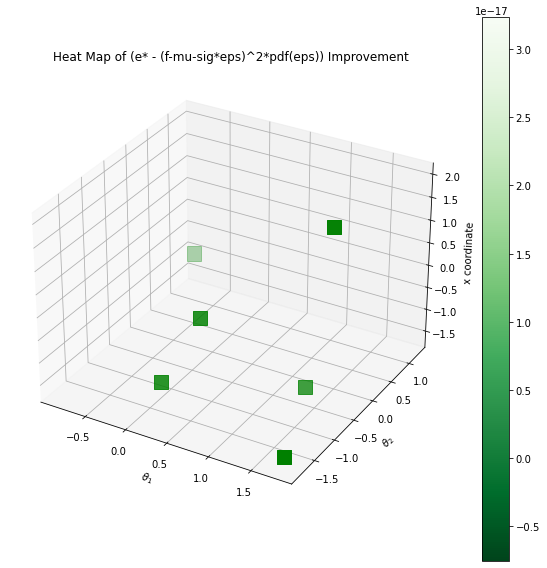

None


In [8]:
Integrand_values = improvement_integral(best_error,model_mean,model_variance,y_exp)
print("Lower Improvement Integrand is \n",Integrand_values[0] )
print("Upper Improvement Integrand is \n",Integrand_values[1] )
print(improvement_integral_plot(test_p,Integrand_values))

[[ 2.45289367 -0.16729301  0.60248648 -1.60081671  0.72211195  0.58505349]
 [ 2.49357541 -0.12546976  0.64446738 -1.56243548  0.76644379  0.62999891]
 [ 2.53425715 -0.08364651  0.68644827 -1.52405424  0.81077563  0.67494433]
 [ 2.57493888 -0.04182325  0.72842916 -1.485673    0.85510748  0.71988975]
 [ 2.61562062  0.          0.77041006 -1.44729177  0.89943932  0.76483516]]
[ 2.45289367 -0.16729301  0.60248648 -1.60081671  0.72211195  0.58505349]
[-0.89033398  0.         -1.02176053 -2.03142451 -1.18445858 -0.86830296]
[ 2.49357541 -0.12546976  0.64446738 -1.56243548  0.76644379  0.62999891]
[-0.80511182  0.         -0.99536381 -2.15856153 -1.14601484 -0.84491427]
[ 2.53425715 -0.08364651  0.68644827 -1.52405424  0.81077563  0.67494433]
[-0.72684315  0.         -0.96794164 -2.2902791  -1.10664183 -0.82049643]
[ 2.57493888 -0.04182325  0.72842916 -1.485673    0.85510748  0.71988975]
[-0.65509825  0.         -0.93961751 -2.42645711 -1.06652342 -0.7951763 ]
[ 2.61562062  0.          0.7704

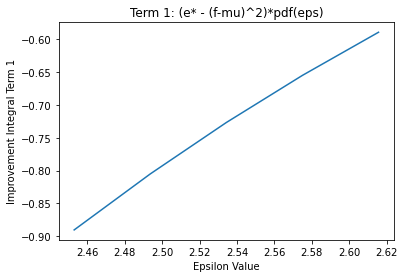

Index:  2


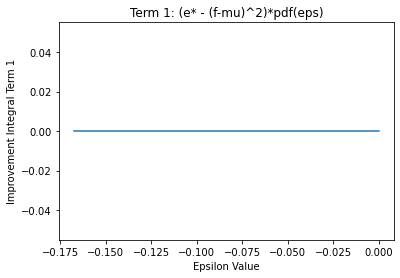

Index:  3


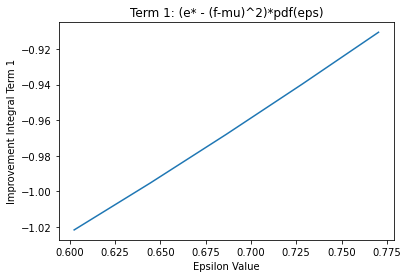

Index:  4


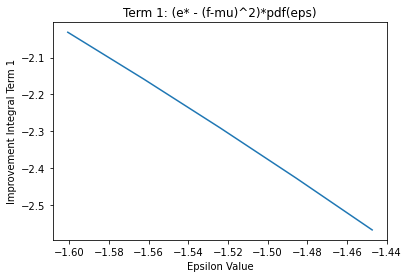

Index:  5


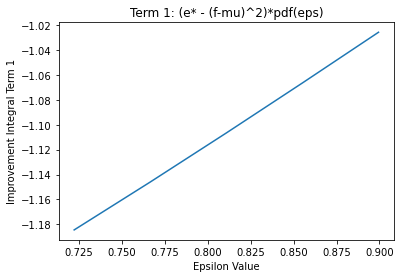

In [11]:
steps = 5
term_num = 1
index_num = 5

I_terms = improvement_int_terms(best_error,model_mean,model_variance,y_exp,steps)

improvement_int_terms_plot(I_terms,term_num, index_num)